# Using MLACS with the Multi-Bennett Aceptance Ratio (MBAR)

In this tutorial, we will show you how to setup MLACS using multiple (same) NPT state. We will also see how to add weight to the sampled configurations using the Multi-Bennett Aceptance Ration (MBAR). 
To illustrate the power of MBAR, we will study the melting of a simple Copper cristal and the EMT potential will be use as reference.

## Setting up the simulation

In this tutorial, we will set up MLACS:
- using 5 NPT states,
- and using the Multi-Bennett Aceptance Ratio (MBAR).

### Setting up the system

The first component is the actual system to be simulated.
In this tutorial, we will simulate a vacancy in copper cristal with a EMT potential.

As input, we can use the `bulk` function of the ASE package.

In [1]:
from ase.build import bulk
at = bulk("Cu", cubic=True).repeat(4)  # This create a 4x4x4 supercell of copper

For the potential, we can use the EMT implementation in ASE

In [2]:
from ase.calculators.emt import EMT
calc = EMT()

### Setting up the states

The second ingredient for a MLACS simulation are states. A good strategy is to sample the same state multiple times to benefit from randomness of the thermodynamic sampling.

We will start by setting up some parameters.

In [3]:
temperature = 400  # The temperature, in K
pressure = 100  # The pressure, in GPa
nsteps = 100  # The number of steps

We also have to provide the path to the LAMMPS binary.

In [4]:
import os
os.environ["ASE_LAMMPSRUN_COMMAND"] = "~/.local/bin/lmp"

Now, we can import the state, that will consist here in a LAMMPS molecular dynamics with a Langevin thermostat set to 300K and a barostat set to 0 GPa. Then the state will be copy 5 times.

In [5]:
from mlacs.state import LammpsState
states = list(LammpsState(temperature, pressure, nsteps=nsteps) for i in range(5))

### Setting up the machine-learning interatomic potential

And the final ingredient is the machine-learning interatomic potential that will drive the molecular dynamics and will be updated from the reference data gathered.

In this example, we will use a SNAP potential. Instead of attributing the same weights on each reference configuration, this time they will be reweighted according to their Boltzmann weights by using the Multi-Bennett Aceptance Ratio (MBAR).

The MBAR is computed using the `pymbar` python package, which is optional when building `mlacs`. So make sure you properly install the `pymbar` python package to go further in the tutorial.

In this case, a SNAP potential need to be set up in three steps:
* define the descriptor

In [6]:
from mlacs.mlip import SnapDescriptor
parameters = {"twojmax": 6}
descriptor = SnapDescriptor(at,
                            parameters=parameters)

* define the MBAR manager

In [7]:
from mlacs.mlip import MbarManager
mbar = MbarManager()

* finally we define the model

In [8]:
from mlacs.mlip import LinearPotential
mlip_mbar = LinearPotential(descriptor, weight=mbar)

## Gathering everything and launching the simulation with MBAR

Now that everything is set up, we can gather everything into a `OtfMlacs` object

In [9]:
from mlacs import OtfMlacs
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_mbar,
               prefix_output='Mbar_Trajectory',
               neq=0)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 03-04-2024  18:44:48


State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 2/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 3/5 :
NPT dynamics as implemented in LA

and launch the simulation for 10 steps. It can take a while ... Time for a cofee break ? 

In [10]:
dyn.run(10)

Step 0
Running initial step
There are 1 unique configuration in the states 
Computation done, creating trajectories

Computing energy with true potential on training configurations

Step 1

Production step for state 1, configuration 1 for this state
Production step for state 2, configuration 1 for this state
Production step for state 3, configuration 1 for this state
Production step for state 4, configuration 1 for this state
Production step for state 5, configuration 1 for this state


Training new MLIP


Number of configurations for training: 2
Number of atomic environments for training: 512

Weighted RMSE Energy    0.0001 eV/at
Weighted MAE Energy     0.0001 eV/at
Weighted RMSE Forces    0.0083 eV/angs
Weighted MAE Forces     0.0046 eV/angs
Weighted RMSE Stress    0.0085 GPa
Weighted MAE Stress     0.0061 GPa

Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with 

Computing the average volume
Average structure:
- cell:    0.000000000000000 angs
- vol/atom:    0.000000000000000 angs^3

Computing the average volume
Average structure:
- cell:    0.000000000000000 angs
- vol/atom:    0.000000000000000 angs^3

Computing the average volume
Average structure:
- cell:    0.000000000000000 angs
- vol/atom:    0.000000000000000 angs^3

Computing the average volume
Average structure:
- cell:    0.000000000000000 angs
- vol/atom:    0.000000000000000 angs^3

Step 6

Production step for state 1, configuration 6 for this state
Production step for state 2, configuration 6 for this state
Production step for state 3, configuration 6 for this state
Production step for state 4, configuration 6 for this state
Production step for state 5, configuration 6 for this state


Training new MLIP

Reached a solution to within tolerance with L-BFGS-B
Solution found within tolerance!
Final gradient norm: 2.5e-05

Number of configurations for training: 27
Number of atomic envi

And that's it !

Note that you can find the computed weights in the MLIP repertory. We can plot them !

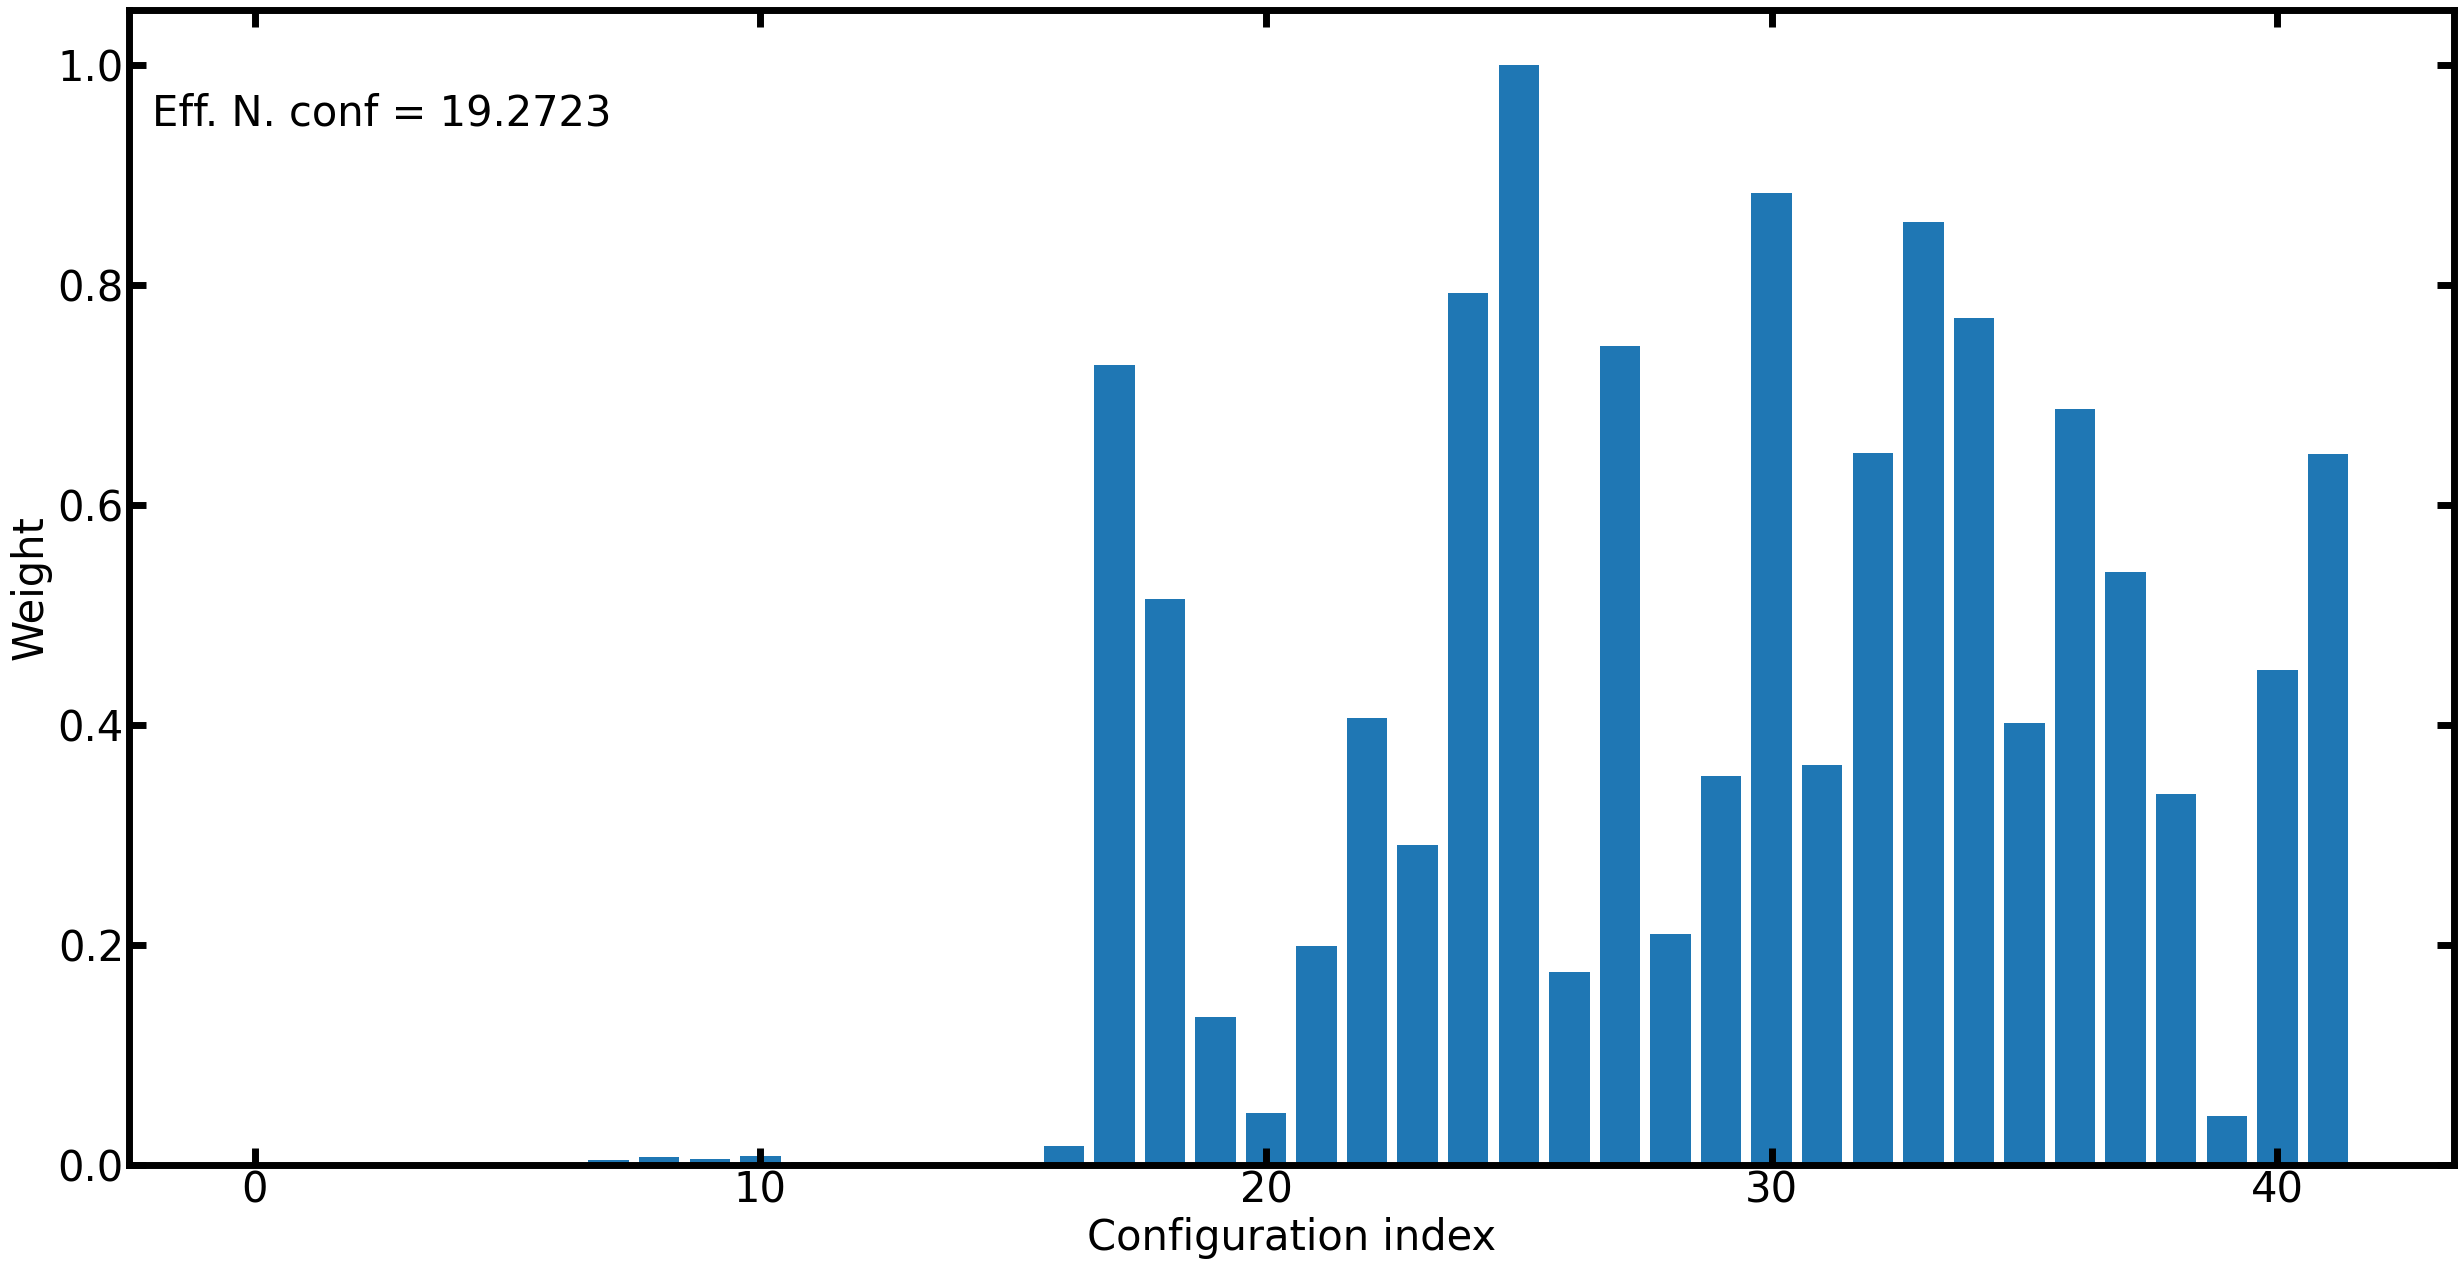

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import plot_weights, init_rcParams

plt.rcParams.update({'figure.figsize': (30,15)})
fig, ax0 = plt.subplots()
init_rcParams()
w = mbar.weight*mbar.get_effective_conf()
w /= max(w)                                  # Just to have weights varying from 0 to 1
ax0 = plot_weights(ax0, w)
plt.show()

You can also notice the very low RMSE and MAE at the end of the MLACS simulation, this is due to reweighting.
As an example, we can fit un new SNAP without the MBAR weights and compare the results.

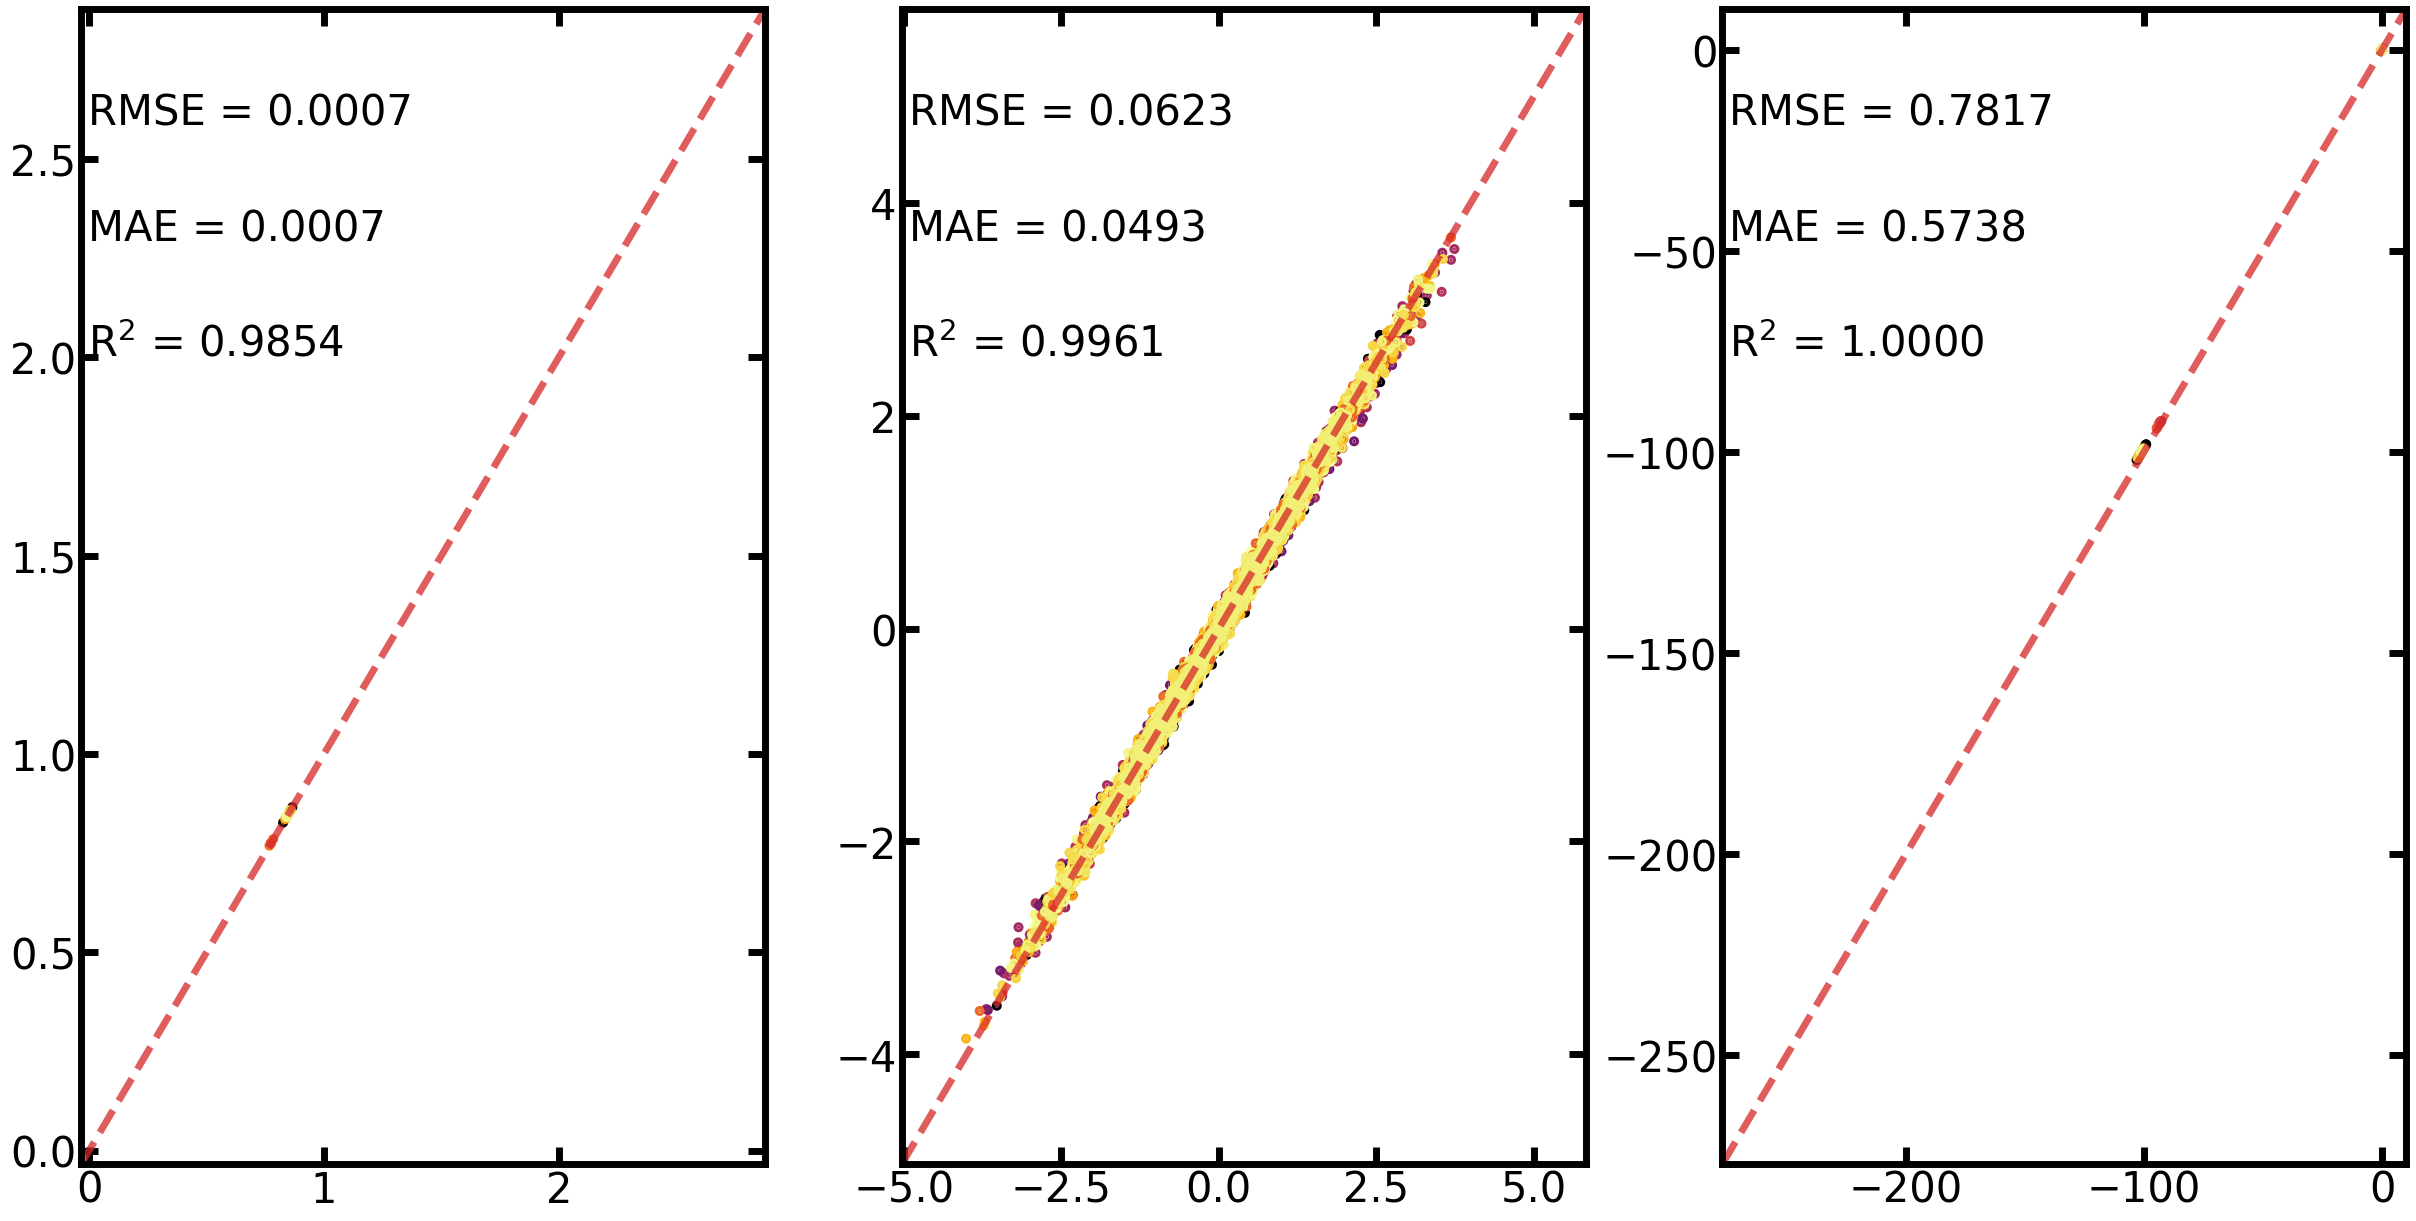

In [21]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('MLIP-Energy_comparison.dat')
f_data = np.loadtxt('MLIP-Forces_comparison.dat')
s_data = np.loadtxt('MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data, weight=mbar.weight)
ax1 = plot_correlation(ax1, f_data, weight=mbar.weight)
ax2 = plot_correlation(ax2, s_data, weight=mbar.weight)
plt.show()

error1 = mlip_mbar.fit_res

## Launch the same simulation with Uniform weighting policy

We can run now run the simulation again with uniform configuration weight (this is the default in MLACS). To do it, we need to redefine the MLIP object without specifying a weighting policy. Then we can recreate an OtfMlacs object and relaunch the simulation ... Time for another cofee ?

In [13]:
mlip_uni = LinearPotential(descriptor)
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_uni,
               prefix_output='Uniform_Trajectory',
               neq=0)
dyn.run(10)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 03-04-2024  18:56:42


State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 2/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 3/5 :
NPT dynamics as implemented in LA

Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Average structure:
- cell:    3.787024558981238 angs
- vol/atom:    2.487926356889695 angs^3

Computing the average volume
Average structure:
- cell:    3.788675405637617 angs
- vol/atom:    2.491086596749083 angs^3

Computing the average volume
Average structure:
- cell:    3.787570199654597 angs
- vol/atom:    2.488787764528620 angs^3

Computing the average volume
Average structure:
- cell:    3.788032758073841 angs
- vol/atom:    2.489798088031980 angs^3

Computing the average volume
Average structure:
- cell:    3.788003124967870 angs
- vol/atom:    2.489703185495904 angs^3

Step 5

Production step for state 1, configuration 5 for this state
Production step for state 2, configuration 5 for this state
Production step for state 3, configuration 5 for this state
Pr

Computing the average volume
Average structure:
- cell:    3.049852106158189 angs
- vol/atom:    1.969238348142921 angs^3

Computing the average volume
Average structure:
- cell:    3.049764229044897 angs
- vol/atom:    1.969055612295832 angs^3



We can replot the correlation functions.

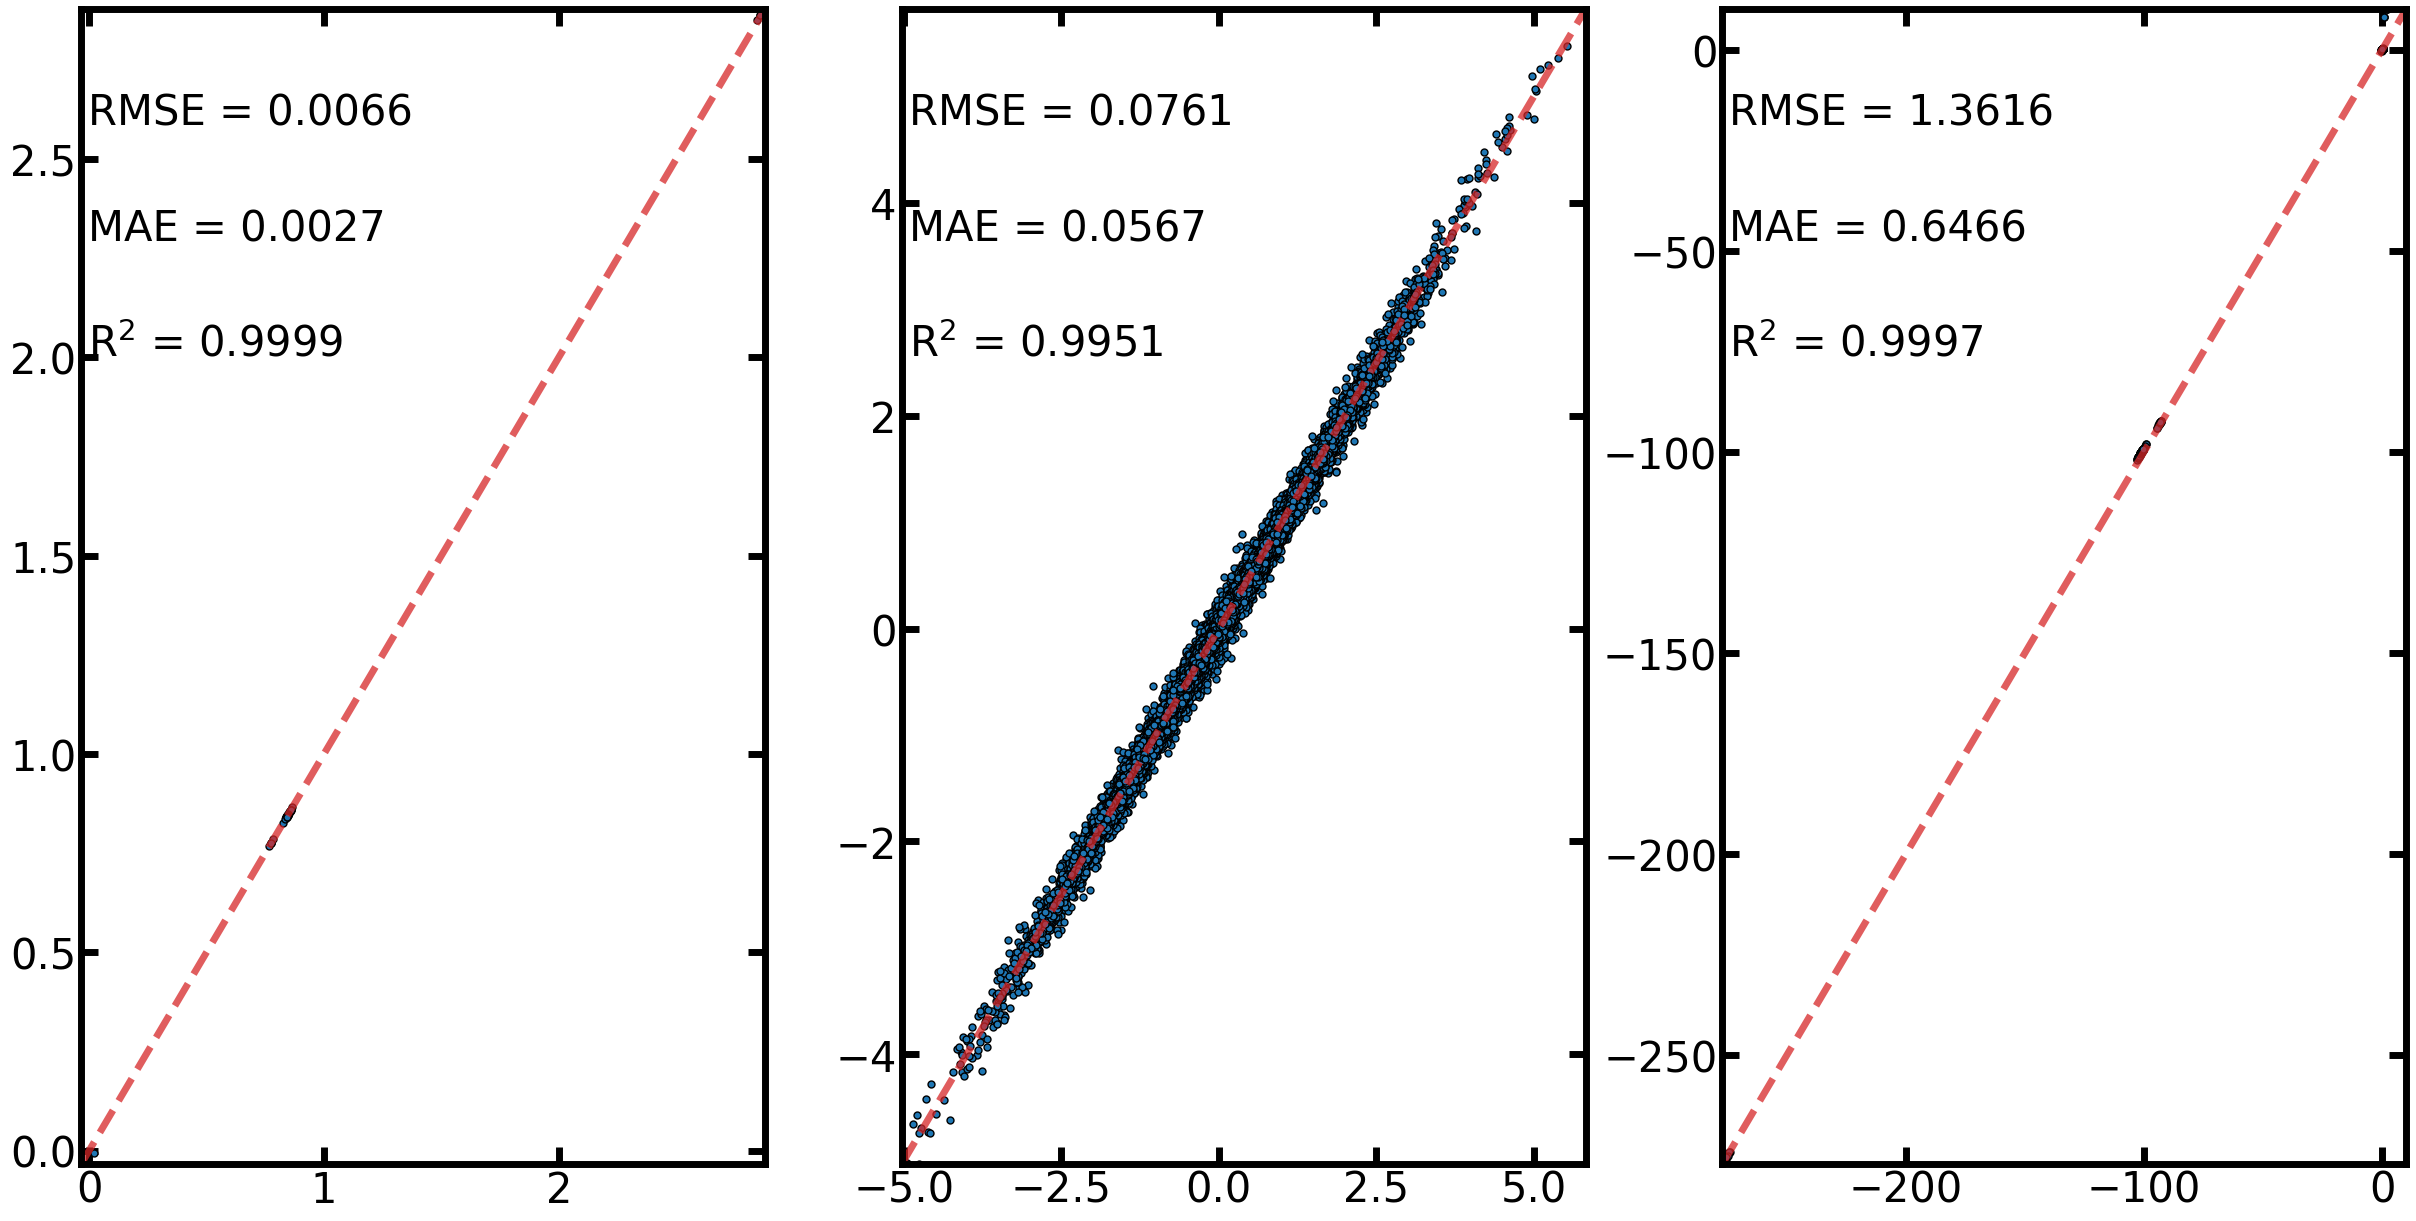

In [14]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('MLIP-Energy_comparison.dat')
f_data = np.loadtxt('MLIP-Forces_comparison.dat')
s_data = np.loadtxt('MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data)
ax1 = plot_correlation(ax1, f_data)
ax2 = plot_correlation(ax2, s_data)
plt.show()

error2 = mlip_uni.fit_res

Ok we can see that the MBAR weighting policy can be useful, specially if your starting configurations are far from the equilibrating ones. In this case, the sampled database is not representative of the reel equilibrating one.

## Replay the simulation with MBAR and the Database Calculator

But we haven't run the last simulation for nothing, the database is not lost. In this part, we will see how we can replay a MLACS simulation without doing new calculations and update the database by adding MBAR weights on the sampling configurations.  

The DatabaseCalc is a calculator that sequentially reads a previously calculated traj files. We will use it in the present example to replay a MLACS. 

In [ ]:
from mlacs.calc import DatabaseCalc

traj = [f'Uniform_Trajectory_{i}.traj' for i in range(1,6)]
train = 'Training_configurations.traj'
calc = DatabaseCalc(trajfile=traj, trainfile=train)

We also need to update the MLIP object by adding MBAR.

In [25]:
mbar = MbarManager()

mlip_mbar = LinearPotential(descriptor, weight=mbar)

dyn = OtfMlacs(at,
               states,
               calc,
               mlip_mbar,
               prefix_output='Replay_Trajectory',
               neq=0)
dyn.run(10)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 03-04-2024  19:26:57


State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 2/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A Langevin thermostat is used
Pressure (GPa)                          100
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       100
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 3/5 :
NPT dynamics as implemented in LA

Production step for state 4, configuration 4 for this state
Production step for state 5, configuration 4 for this state


Training new MLIP

Reached a solution to within tolerance with L-BFGS-B
Solution found within tolerance!
Final gradient norm: 1.01e-05

Number of configurations for training: 17
Number of atomic environments for training: 4352

Using MBAR weighting
Effective number of configurations:    5.57735
Number of uncorrelated snapshots for each k state:
[2 5 5 5]
Weighted RMSE Energy    0.2382 eV/at
Weighted MAE Energy     0.1507 eV/at
Weighted RMSE Forces    0.1701 eV/angs
Weighted MAE Forces     0.0800 eV/angs
Weighted RMSE Stress    17.5031 GPa
Weighted MAE Stress     7.9268 GPa

Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Average structure:
- cell:    5.223263409566798 angs
- vol/atom:    3.595

Computing the average volume
Average structure:
- cell:    5.230455078873844 angs
- vol/atom:    3.602312682672773 angs^3

Computing the average volume
Average structure:
- cell:    5.229190290505913 angs
- vol/atom:    3.600290058551025 angs^3

Computing the average volume
Average structure:
- cell:    5.229634378617023 angs
- vol/atom:    3.601000187014735 angs^3

Step 9

Production step for state 1, configuration 9 for this state
Production step for state 2, configuration 9 for this state
Production step for state 3, configuration 9 for this state
Production step for state 4, configuration 9 for this state
Production step for state 5, configuration 9 for this state


Training new MLIP

Reached a solution to within tolerance with L-BFGS-B
Solution found within tolerance!
Final gradient norm: 2.91e-05

Number of configurations for training: 42
Number of atomic environments for training: 10752

Using MBAR weighting
Effective number of configurations:   18.73697
Number of uncorrelated s

We can also plot the weight obtained from the uniform sampling trajectory.

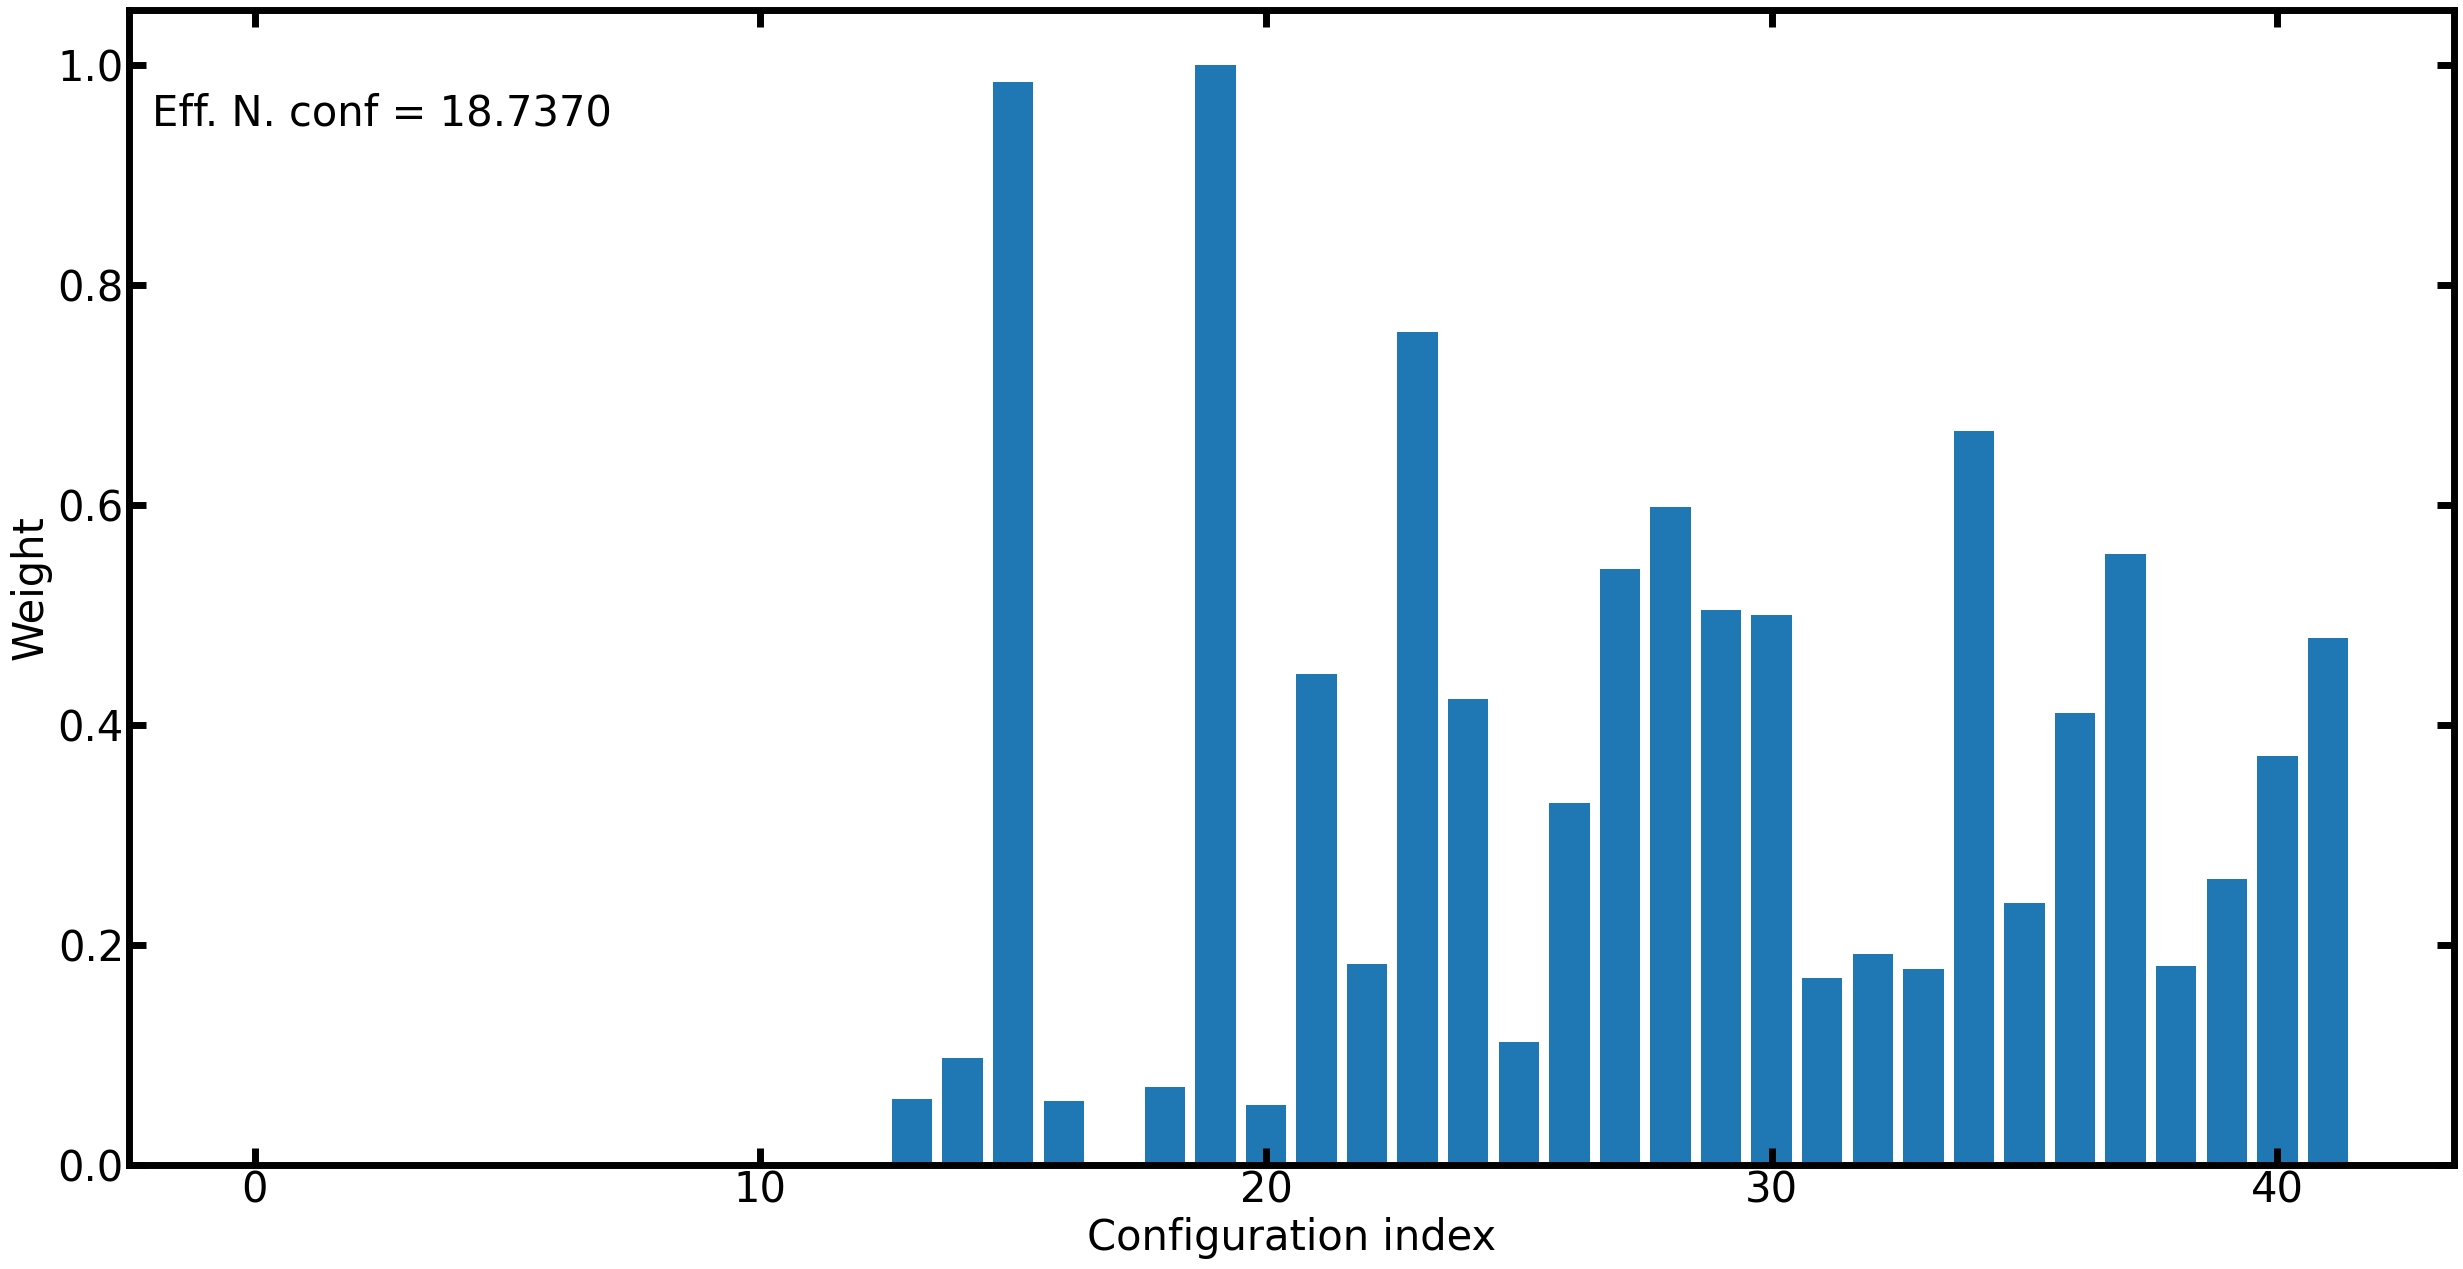

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import plot_weights, init_rcParams

plt.rcParams.update({'figure.figsize': (30,15)})
fig, ax0 = plt.subplots()
init_rcParams()
w = mbar.weight*mbar.get_effective_conf()
w /= max(w)                                  # Just to have weights varying from 0 to 1
ax0 = plot_weights(ax0, w)
plt.show()

You can see that the weight from the first configurations are zero, meaning that they very far away from the equilibrium sampled state. 

A new MLIP can be fitted using the MBAR weights obtained from the uniform sampling database. 

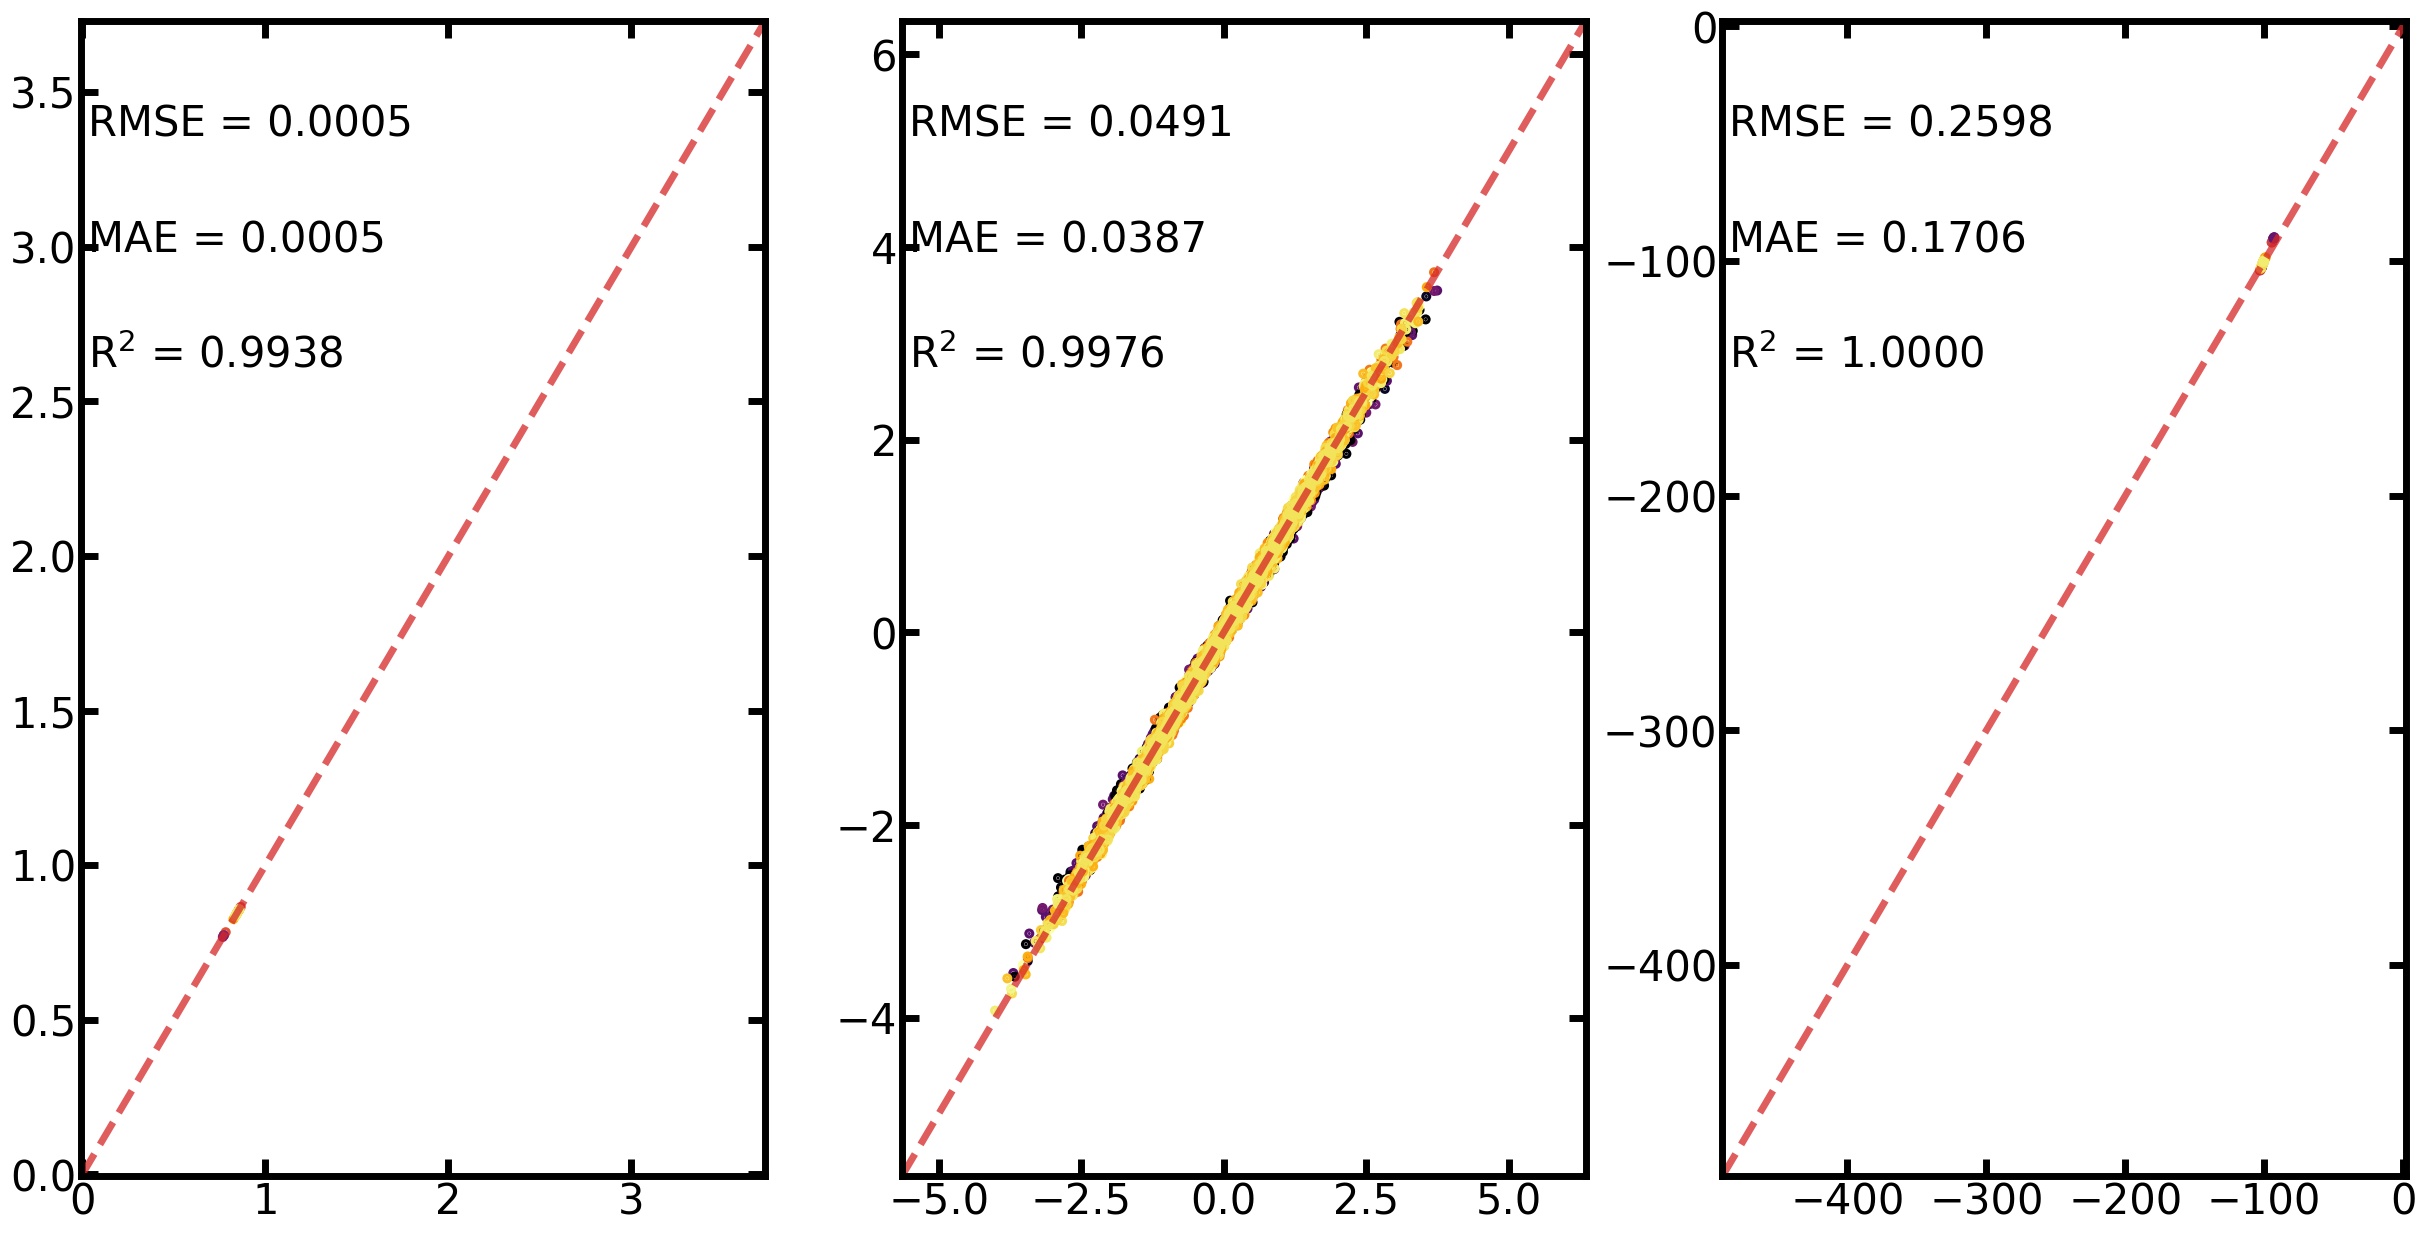

In [28]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('MLIP-Energy_comparison.dat')
f_data = np.loadtxt('MLIP-Forces_comparison.dat')
s_data = np.loadtxt('MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data, weight=mbar.weight)
ax1 = plot_correlation(ax1, f_data, weight=mbar.weight)
ax2 = plot_correlation(ax2, s_data, weight=mbar.weight)
plt.show()

error3 = mlip_mbar.fit_res

At the end we can compare the errors from the three different situations:

In [32]:
def results_errors(results):
    txt = f"RMSE Energy    {results[0, 0]:.4f} eV/at\n"
    txt += f"MAE Energy     {results[1, 0]:.4f} eV/at\n"
    txt += f"RMSE Forces    {results[0, 1]:.4f} eV/angs\n"
    txt += f"MAE Forces     {results[1, 1]:.4f} eV/angs\n"
    txt += f"RMSE Stress    {results[0, 2]:.4f} GPa\n"
    txt += f"MAE Stress     {results[1, 2]:.4f} GPa\n"
    return txt
    
txt = 'MLACS sampling with MBAR weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error1)
txt += '\n'
txt += 'MLACS sampling with uniform weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error2)
txt += '\n'
txt += 'MLACS uniform sampling with MBAR weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error3)
print(txt)

MLACS sampling with MBAR weights:
------------------------------------------------
RMSE Energy    0.0005 eV/at
MAE Energy     0.0004 eV/at
RMSE Forces    0.0498 eV/angs
MAE Forces     0.0393 eV/angs
RMSE Stress    0.6689 GPa
MAE Stress     0.4703 GPa

MLACS sampling with uniform weights:
------------------------------------------------
RMSE Energy    0.0066 eV/at
MAE Energy     0.0027 eV/at
RMSE Forces    0.0761 eV/angs
MAE Forces     0.0567 eV/angs
RMSE Stress    1.3616 GPa
MAE Stress     0.6466 GPa

MLACS uniform sampling with MBAR weights:
------------------------------------------------
RMSE Energy    0.0005 eV/at
MAE Energy     0.0005 eV/at
RMSE Forces    0.0491 eV/angs
MAE Forces     0.0387 eV/angs
RMSE Stress    0.2598 GPa
MAE Stress     0.1706 GPa

